In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/updated/updated.csv
/kaggle/input/updated1/updated1.csv


In [2]:
import regex as re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def decontracted(text):
    # specific
    text = re.sub("won't", "will not", text)
    text = re.sub("can't", "can not", text)

    # general
    text = re.sub("n't", " not", text)
    text = re.sub("'re", " are", text)
    text = re.sub("'s", " is", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'t", " not", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'m", " am", text)

    return text

def process(text):
    text = text.strip()
    text = decontracted(text)
    text = re.sub(r'http\S+', '', text)
#     text = re.sub(r'[^A-Za-z ]+', ' ', text)
    text = re.sub("\s{2,}"," ",text)
    text = text.lower()
    return text

def processed_df(df):
    df.text = df.text.apply(lambda x: process(x))
    return df

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('../input/updated1/updated1.csv')
df = df[['text','labels']]
# df = processed_df(df)
print(df.shape)
df.head()

(36742, 2)


,text,labels
0,"i recently launched a website, [www.adhdeviden...",adhd
1,did you ace your test test? get a new promotio...,adhd
2,tldr; just my personal experience with adhd-pi...,adhd
3,basically the title.. i often find myself eati...,adhd
4,i just tried to get my rx from walmart pharmac...,adhd


In [4]:
df.loc[df['labels'] == 'apd', 'labels'] = 'schizoid + apd'
df.loc[df['labels'] == 'schizoid', 'labels'] = 'schizoid + apd'

In [5]:
df.labels.value_counts()

abuse                       2540
addiction                   2310
aspd+narcissism             2260
schizoid + apd              2076
sexualorientation           2053
eatingdisorder              2025
narcissisticabuse           1928
anxiety                     1796
OCD                         1674
grief                       1643
psy+schizo                  1411
work_issues                 1190
family_conflicts_mild       1150
relationship_issues_mild     951
insomnia                     914
depression                   910
dpd                          909
bpd                          884
selfesteem                   869
suicide                      859
bipolar                      856
parenting                    830
bdd                          826
adhd                         773
sexualdisorder               754
autism                       717
procrasination               682
violence                     567
hpd                          229
ppd                          156
Name: labe

In [6]:
df = df.dropna()
print(df.isnull().sum())
df.shape

text      0
labels    0
dtype: int64


(36742, 2)

In [7]:
!pip install -q transformers ipython-autotime datasets
%load_ext autotime

time: 465 µs (started: 2022-08-10 15:19:08 +00:00)


In [8]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from transformers import AutoTokenizer,AutoModel, DataCollatorWithPadding ,TrainingArguments,AutoModelForSequenceClassification,EarlyStoppingCallback,TextClassificationPipeline,FlaxBertForSequenceClassification
from datasets import load_dataset,load_metric
import datasets
import os
os.environ["WANDB_DISABLED"] = "true"

time: 10.9 s (started: 2022-08-10 15:19:08 +00:00)


In [9]:
df=df.sample(frac=1).reset_index(drop=True)
labels_list=list(df.labels.unique())
labels_list.sort()
encoded_dict = dict(zip(labels_list, range(len(labels_list))))
res = dict((v,k) for k,v in encoded_dict.items())
print(res)
print(encoded_dict)
def fn(df,encoded_dict,labels_list):
  df["labels"] = df.labels.map(encoded_dict)
  return df,encoded_dict,labels_list
df,encoded_dict,labels=fn(df,encoded_dict,labels_list)
df1 = df
# df=df[["text","labels"]]
df = df.drop_duplicates(subset = 'text')
df.to_csv('full_data.csv', index = False)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2,stratify=df["labels"], random_state = 42)
test.to_csv("test_data.csv",index=False)
train.to_csv("train_data.csv",index=False)

{0: 'OCD', 1: 'abuse', 2: 'addiction', 3: 'adhd', 4: 'anxiety', 5: 'aspd+narcissism', 6: 'autism', 7: 'bdd', 8: 'bipolar', 9: 'bpd', 10: 'depression', 11: 'dpd', 12: 'eatingdisorder', 13: 'family_conflicts_mild', 14: 'grief', 15: 'hpd', 16: 'insomnia', 17: 'narcissisticabuse', 18: 'parenting', 19: 'ppd', 20: 'procrasination', 21: 'psy+schizo', 22: 'relationship_issues_mild', 23: 'schizoid + apd', 24: 'selfesteem', 25: 'sexualdisorder', 26: 'sexualorientation', 27: 'suicide', 28: 'violence', 29: 'work_issues'}
{'OCD': 0, 'abuse': 1, 'addiction': 2, 'adhd': 3, 'anxiety': 4, 'aspd+narcissism': 5, 'autism': 6, 'bdd': 7, 'bipolar': 8, 'bpd': 9, 'depression': 10, 'dpd': 11, 'eatingdisorder': 12, 'family_conflicts_mild': 13, 'grief': 14, 'hpd': 15, 'insomnia': 16, 'narcissisticabuse': 17, 'parenting': 18, 'ppd': 19, 'procrasination': 20, 'psy+schizo': 21, 'relationship_issues_mild': 22, 'schizoid + apd': 23, 'selfesteem': 24, 'sexualdisorder': 25, 'sexualorientation': 26, 'suicide': 27, 'viol

In [10]:
dataset_temp = load_dataset('csv', data_files={'train': 'train_data.csv', 'test': 'test_data.csv'})
dataset=dataset_temp["train"].train_test_split(train_size=0.9)
dataset["validation"] = dataset.pop("test")
dataset["test"]=dataset_temp["test"]
print(dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c9dbdbb53ee665d9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 26453
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2940
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 7349
    })
})
time: 1.27 s (started: 2022-08-10 15:19:20 +00:00)


In [11]:
checkpoint = "ProsusAI/finbert"
#next ""ctrl"
# checkpoint="bert-base-uncased"
# "jboomc/rotten_tomatoes_finetuned"best
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def tokenize_function(example):
    return tokenizer(example["text"] ,truncation=True,max_length= 512)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=30,ignore_mismatched_sizes=True,id2label=res,label2id=encoded_dict,)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='macro')
    precision = precision_score(y_true=labels, y_pred=pred,average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred,average="macro")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([30, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([30]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 53.4 s (started: 2022-08-10 15:19:22 +00:00)


In [12]:
from transformers import Trainer
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="steps",
    metric_for_best_model = 'accuracy',
    eval_steps=500,
    logging_steps=100,
    load_best_model_at_end=True,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=3
)
#ratio 5e5 10 0.01 
# ratio 5e5 15 0.01 72
# ratio 4e5 20 0.02 69
#6e5 0.01 15 68 1000
#5e5 0.01 15 67 900
# 5e5 0.01 15 66 1200
#5e5 0.01 15 69 1000
#4e5 0.02 15 65
#4e5 0.02 5 67
#5e5 0.05 10 67
# 4e5 0.08 10 66
#4e5 0.01 5 66
#5e5 0.01 5 68
#5e5 0.02 15 65
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)]
)
trainer.train()

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 26453
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9921


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.911000,1.744476,0.548980,0.500788,0.464137,0.440147
1000,1.557100,1.422155,0.626531,0.642639,0.570994,0.579364
1500,1.343700,1.242644,0.672789,0.696397,0.635418,0.648299
2000,1.293800,1.187544,0.693197,0.714912,0.648220,0.663797
2500,1.140800,1.143736,0.694898,0.715902,0.660197,0.670612
3000,1.184100,1.105327,0.714966,0.741869,0.678993,0.691488
3500,0.872000,1.091867,0.717687,0.743247,0.675608,0.696037
4000,0.835200,1.061804,0.716667,0.737950,0.684552,0.697898
4500,0.857100,1.065384,0.720748,0.737777,0.686251,0.697745
5000,0.829500,1.005866,0.729592,0.739156,0.701421,0.707798


***** Running Evaluation *****
  Num examples = 2940
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2940
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contro

TrainOutput(global_step=8000, training_loss=1.0523747930526732, metrics={'train_runtime': 4086.9775, 'train_samples_per_second': 19.418, 'train_steps_per_second': 2.427, 'total_flos': 1.511835313444092e+16, 'train_loss': 1.0523747930526732, 'epoch': 2.42})

time: 1h 8min 12s (started: 2022-08-10 15:20:15 +00:00)


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
from datasets import load_metric
metric = load_metric("accuracy")
predictions = trainer.predict(tokenized_datasets["test"])
# print(predictions.predictions.shape, predictions.label_ids.shape)
preds = np.argmax(predictions.predictions, axis=-1)
print(metric.compute(predictions=preds, references=predictions.label_ids))
# print(encoded_dict)
# print("----------------------------------------------------")
# print(labels)
print("----------------------------------------------------")
y_true=test.labels.tolist()
y_pred=preds
set(y_true),set(y_pred)
from collections import Counter
# print(Counter(preds))
# print(encoded_dict)
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred,target_names=labels))


***** Running Prediction *****
  Num examples = 7349
  Batch size = 16


{'accuracy': 0.7251326711117159}
----------------------------------------------------
                          precision    recall  f1-score   support

                     OCD       0.72      0.73      0.72       335
                   abuse       0.64      0.70      0.67       508
               addiction       0.77      0.92      0.84       462
                    adhd       0.75      0.61      0.67       155
                 anxiety       0.65      0.66      0.65       359
         aspd+narcissism       0.63      0.73      0.68       452
                  autism       0.61      0.59      0.60       143
                     bdd       0.66      0.70      0.68       165
                 bipolar       0.59      0.68      0.63       171
                     bpd       0.57      0.58      0.57       177
              depression       0.46      0.32      0.38       182
                     dpd       0.80      0.53      0.64       182
          eatingdisorder       0.85      0.84      0.85

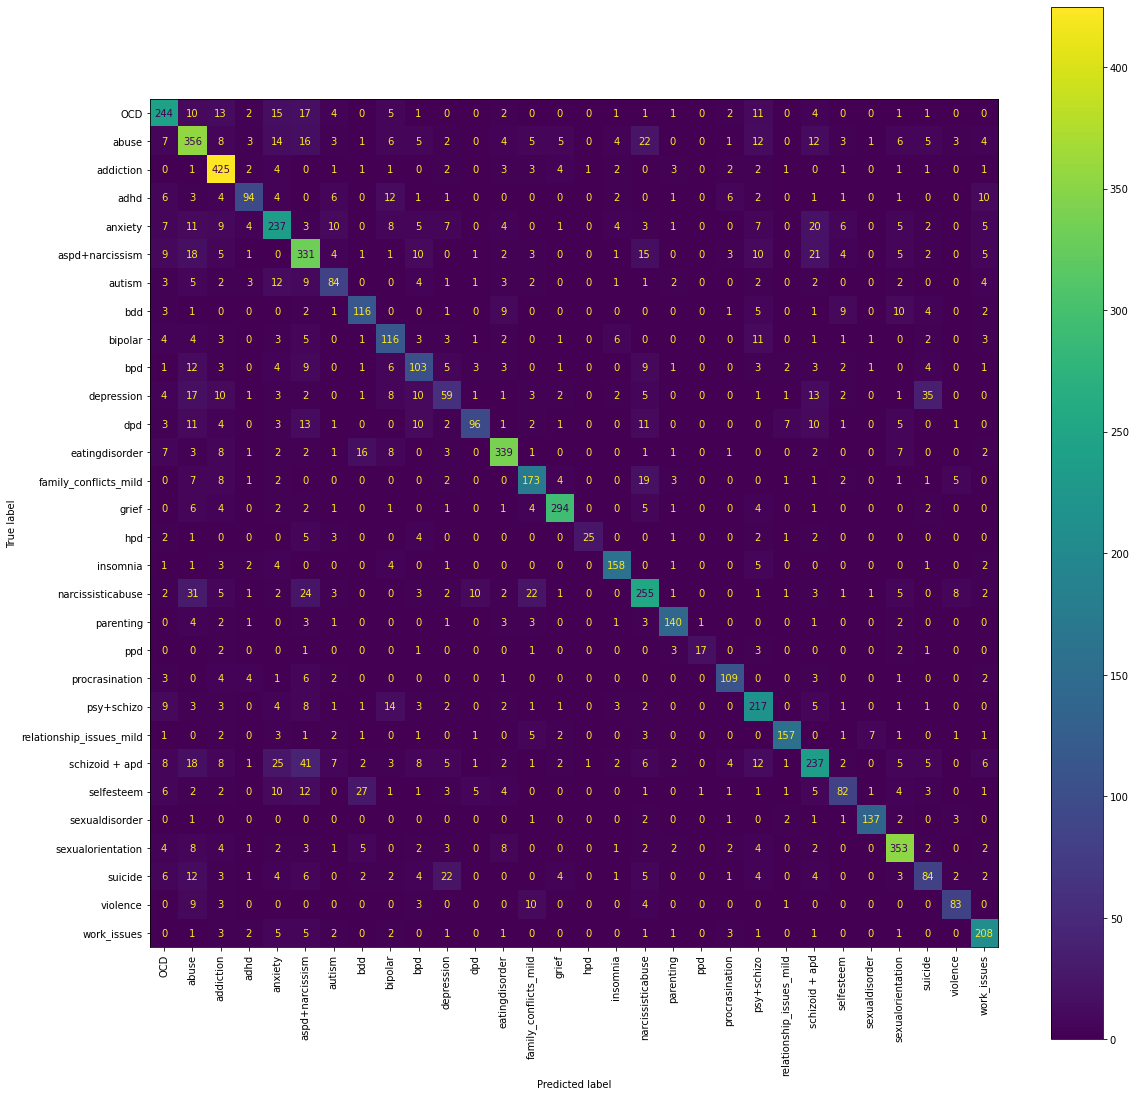

time: 2.75 s (started: 2022-08-10 16:30:33 +00:00)


In [14]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=labels)
fig, ax = plt.subplots(figsize=(19,19))
disp.plot(ax=ax,xticks_rotation = 'vertical')

In [15]:
dataset_pred= load_dataset('csv', data_files={'full': 'full_data.csv'})
tokenized_datasets_pred = dataset_pred.map(tokenize_function, batched=True)
predictions = trainer.predict(tokenized_datasets_pred["full"])
preds_n = np.argmax(predictions.predictions, axis=-1)
y_true=train.labels.tolist()
y_pred_n=preds_n

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-976cc910dc3c202e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36742
  Batch size = 16


time: 10min 44s (started: 2022-08-10 16:30:36 +00:00)


In [16]:
from scipy.special import softmax
y_pred_s = softmax(predictions[0],axis = 1)

time: 10 ms (started: 2022-08-10 16:41:20 +00:00)


In [17]:
df[labels] = y_pred_s

time: 13.9 ms (started: 2022-08-10 16:41:20 +00:00)


In [18]:
df = df.drop_duplicates(subset='text')
df.shape

(36742, 32)

time: 129 ms (started: 2022-08-10 16:41:20 +00:00)


In [19]:
df.head()

,text,labels,OCD,abuse,addiction,adhd,anxiety,aspd+narcissism,autism,bdd,...,procrasination,psy+schizo,relationship_issues_mild,schizoid + apd,selfesteem,sexualdisorder,sexualorientation,suicide,violence,work_issues
0,has it helped you? please let me know ;; i am ...,0,0.638398,0.018099,0.003984,0.002825,0.036864,0.051488,0.018964,0.026707,...,0.003054,0.046132,0.000746,0.023336,0.004548,0.001356,0.006691,0.004030,0.000093,0.001576
1,i recently realized that the hard part of imag...,11,0.005633,0.006642,0.006688,0.001878,0.003282,0.113061,0.001133,0.002606,...,0.000507,0.001603,0.005265,0.015896,0.008710,0.000756,0.003149,0.002562,0.002792,0.000763
2,we met through a bufo ceremony held by mutual ...,22,0.001748,0.020795,0.001550,0.001368,0.008484,0.019298,0.001436,0.001583,...,0.000313,0.000844,0.125910,0.012411,0.017008,0.013730,0.003240,0.001032,0.027996,0.000827
3,like why is it that individuals lend themselve...,12,0.002662,0.000777,0.000947,0.000557,0.000366,0.003992,0.001263,0.005339,...,0.001058,0.001282,0.000271,0.001494,0.000898,0.000261,0.000759,0.000225,0.000041,0.000288
4,"no contact, pulled the plug out of the narciss...",17,0.000206,0.010723,0.000306,0.000057,0.000150,0.006849,0.000241,0.000103,...,0.000075,0.000137,0.000099,0.000316,0.000311,0.000110,0.000400,0.000359,0.001226,0.000115


time: 20.8 ms (started: 2022-08-10 16:41:20 +00:00)


In [20]:
df['true_label'] = df['labels'].apply(lambda x: res[x])
df.head()

,text,labels,OCD,abuse,addiction,adhd,anxiety,aspd+narcissism,autism,bdd,...,psy+schizo,relationship_issues_mild,schizoid + apd,selfesteem,sexualdisorder,sexualorientation,suicide,violence,work_issues,true_label
0,has it helped you? please let me know ;; i am ...,0,0.638398,0.018099,0.003984,0.002825,0.036864,0.051488,0.018964,0.026707,...,0.046132,0.000746,0.023336,0.004548,0.001356,0.006691,0.004030,0.000093,0.001576,OCD
1,i recently realized that the hard part of imag...,11,0.005633,0.006642,0.006688,0.001878,0.003282,0.113061,0.001133,0.002606,...,0.001603,0.005265,0.015896,0.008710,0.000756,0.003149,0.002562,0.002792,0.000763,dpd
2,we met through a bufo ceremony held by mutual ...,22,0.001748,0.020795,0.001550,0.001368,0.008484,0.019298,0.001436,0.001583,...,0.000844,0.125910,0.012411,0.017008,0.013730,0.003240,0.001032,0.027996,0.000827,relationship_issues_mild
3,like why is it that individuals lend themselve...,12,0.002662,0.000777,0.000947,0.000557,0.000366,0.003992,0.001263,0.005339,...,0.001282,0.000271,0.001494,0.000898,0.000261,0.000759,0.000225,0.000041,0.000288,eatingdisorder
4,"no contact, pulled the plug out of the narciss...",17,0.000206,0.010723,0.000306,0.000057,0.000150,0.006849,0.000241,0.000103,...,0.000137,0.000099,0.000316,0.000311,0.000110,0.000400,0.000359,0.001226,0.000115,narcissisticabuse


time: 26 ms (started: 2022-08-10 16:41:20 +00:00)


In [21]:
df['predicted_label'] = y_pred_n
df['predicted_label'] = df['predicted_label'].apply(lambda x: res[x])
df.head()

,text,labels,OCD,abuse,addiction,adhd,anxiety,aspd+narcissism,autism,bdd,...,relationship_issues_mild,schizoid + apd,selfesteem,sexualdisorder,sexualorientation,suicide,violence,work_issues,true_label,predicted_label
0,has it helped you? please let me know ;; i am ...,0,0.638398,0.018099,0.003984,0.002825,0.036864,0.051488,0.018964,0.026707,...,0.000746,0.023336,0.004548,0.001356,0.006691,0.004030,0.000093,0.001576,OCD,OCD
1,i recently realized that the hard part of imag...,11,0.005633,0.006642,0.006688,0.001878,0.003282,0.113061,0.001133,0.002606,...,0.005265,0.015896,0.008710,0.000756,0.003149,0.002562,0.002792,0.000763,dpd,dpd
2,we met through a bufo ceremony held by mutual ...,22,0.001748,0.020795,0.001550,0.001368,0.008484,0.019298,0.001436,0.001583,...,0.125910,0.012411,0.017008,0.013730,0.003240,0.001032,0.027996,0.000827,relationship_issues_mild,dpd
3,like why is it that individuals lend themselve...,12,0.002662,0.000777,0.000947,0.000557,0.000366,0.003992,0.001263,0.005339,...,0.000271,0.001494,0.000898,0.000261,0.000759,0.000225,0.000041,0.000288,eatingdisorder,eatingdisorder
4,"no contact, pulled the plug out of the narciss...",17,0.000206,0.010723,0.000306,0.000057,0.000150,0.006849,0.000241,0.000103,...,0.000099,0.000316,0.000311,0.000110,0.000400,0.000359,0.001226,0.000115,narcissisticabuse,narcissisticabuse


time: 25.8 ms (started: 2022-08-10 16:41:20 +00:00)


In [22]:
df = df[['text', 'true_label', 'predicted_label']]
df.head()

,text,true_label,predicted_label
0,has it helped you? please let me know ;; i am ...,OCD,OCD
1,i recently realized that the hard part of imag...,dpd,dpd
2,we met through a bufo ceremony held by mutual ...,relationship_issues_mild,dpd
3,like why is it that individuals lend themselve...,eatingdisorder,eatingdisorder
4,"no contact, pulled the plug out of the narciss...",narcissisticabuse,narcissisticabuse


time: 9.61 ms (started: 2022-08-10 16:41:20 +00:00)


In [23]:
results = df
results[results['true_label'] == results['predicted_label']].shape[0]/results.shape[0]

0.83242610636329

time: 9.43 ms (started: 2022-08-10 16:41:20 +00:00)


In [24]:
df_in = results[results['true_label'] != results['predicted_label']]
df_in.shape

(6157, 3)

time: 6.23 ms (started: 2022-08-10 16:41:20 +00:00)


In [25]:
df_in.to_csv('incorrect_dis.csv',index = False)

time: 130 ms (started: 2022-08-10 16:41:20 +00:00)


In [26]:
df.to_csv('full.csv', index = False)

time: 847 ms (started: 2022-08-10 16:41:21 +00:00)
